## TOC
1. **LB1**: Import libraries
- **Future Value of Investment**
2. **IP1**: Import data from Yahoo Finance 
3. **IP2**: Calculate Log return, remove unused columns
4. **IP3**: Calculate Future Value of each index
- **Volatility 1: High - Low**
5. **VL1**: Calculate simple volatility in dataset with max - min
6. **VL2**: Calculate simple volatility in the latest data points with max - min
7. **VL3**: Standardize volatility by dividing the most current price
- **Volatility 2: with Moving Averages (Rolling Distance)**
8. **MA1**: Set rolling average, then plot it
9. **MA2**: Calculate Rolling Distance
- **Volatility 3: Standard Deviation**
10. **SD1**: Calculate Volatility with Standard Deviation
- **Volatility 4: Comparison Function for different tickers**
11. **CF1**: Comparison Function 

In [3]:
# LB1
import datetime
from datetime import date

import numpy as np
import pandas as pd
import pandas_datareader.data as web
import seaborn as sns
import yfinance as yfin
from matplotlib import pyplot as plt

pd.options.display.float_format = "{:,.3f}".format
yfin.pdr_override()

## Future Value of Investment

In [4]:
# IP1
start = datetime.date.today()-datetime.timedelta(365)
end = datetime.date.today()

ticker_list = ["^GSPC", "^RUT"]

prices = web.DataReader(ticker_list, start, end)["Adj Close"]

# Rename column to make names more intuitive
prices = prices.rename(columns={"^GSPC": "SP500", "^RUT": "Russell2000"})

[*********************100%***********************]  2 of 2 completed


In [5]:
prices

,SP500,Russell2000
Date,,
2022-06-23,"3,795.730","1,711.670"
2022-06-24,"3,911.740","1,765.740"
2022-06-27,"3,900.110","1,771.740"
2022-06-28,"3,821.550","1,738.840"
2022-06-29,"3,818.830","1,719.370"
...,...,...
2023-06-15,"4,425.840","1,889.280"
2023-06-16,"4,409.590","1,875.470"
2023-06-20,"4,388.710","1,866.700"


In [6]:
# IP2: Calculate Log return, remove unused columns
df = np.log(prices) - np.log(prices.shift(1))
df = df.iloc[1:, 0:]

In [7]:
df.head()

,SP500,Russell2000
Date,,
2022-06-24,0.030,0.031
2022-06-27,-0.003,0.003
2022-06-28,-0.020,-0.019
2022-06-29,-0.001,-0.011
2022-06-30,-0.009,-0.007


In [8]:
# IP3: Calculate Future Value of each index
#   - Calculate mean (expected value) of log return of each index
#   - Assuming expected value remains constant for everyday, multiply it with 252 trading days, 10 years, 1000$.
df.mean() * 100
np.exp(df.mean() * 252 * 10) * 1000

SP500         4,252.566
Russell2000   2,167.246
dtype: float64

## Volatility 1: High - Low

In [9]:
# VL1: Calculate simple volatility in dataset with max - min
prices.max() - prices.min()

SP500         848.810
Russell2000   365.470
dtype: float64

In [10]:
# VL2: Calculate simple volatility in the latest data points with max - min
currYear = prices.loc[
    date.today() - datetime.timedelta(365) : date.today()  # noqa E203
]
currYear.max() - currYear.min()

SP500         848.810
Russell2000   365.470
dtype: float64

In [11]:
# VL3: Standardize volatility by dividing the most current price
# It is hard if you compare volatility of 2 different datasets, since they have different starting points.
# So standardize it by dividing by the current price of the index
(currYear.max() - currYear.min()) / prices.iloc[-1]

SP500         0.194
Russell2000   0.198
dtype: float64

## Volatility 2: With Moving Averages (Rolling Distance)

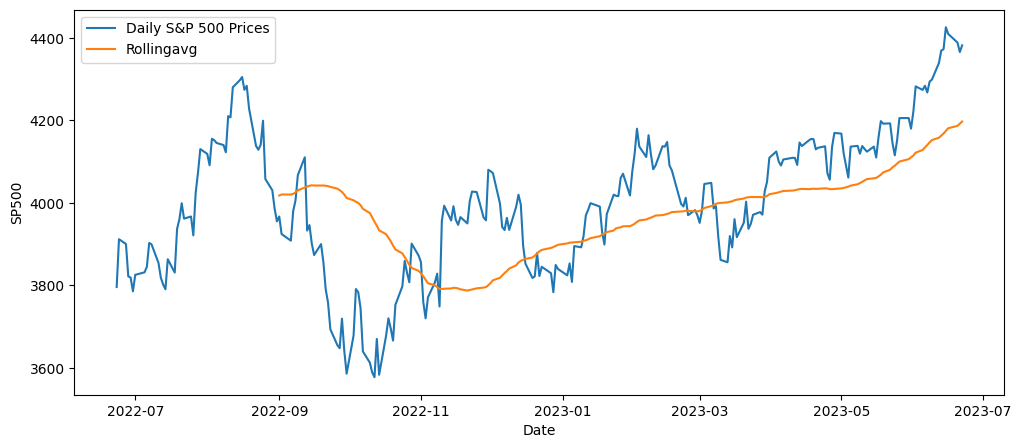

In [12]:
# MA1: Set rolling average, then plot it
prices["SP500 50 day_rolling_avg"] = prices.SP500.rolling(50).mean()

# set figure size
plt.figure(figsize=(12, 5))

# plot a simple time series plot using seaborn.lineplot()
sns.lineplot(x="Date", y="SP500", data=prices, label="Daily S&P 500 Prices")

# plot rolling average
sns.lineplot(x="Date", y="SP500 50 day_rolling_avg", data=prices, label="Rollingavg");

In [13]:
# MA2: Calculate Rolling Distance 
# 1. taking the distance between the moving average line and each data point 
# 2. standardize the distance by dividing the price
# 3. take average of these standardized distance
((abs(prices - prices.rolling(50).mean())) / prices).mean()

SP500                      0.031
Russell2000                0.038
SP500 50 day_rolling_avg   0.015
dtype: float64

## Volatility 3: Standard Deviation

In [14]:
# SD1: Calculate Volatility with Standard Deviation
prices.std()

SP500                      174.431
Russell2000                 78.478
SP500 50 day_rolling_avg    99.737
dtype: float64

## Volatility 4: Comparison Function for different tickers 
- With High-Low, SMA, Standard Deviation Volatility

In [15]:
# CF1: Comparison Function 
def investCompare(startTime, endTime, tickers):
    # pull price data from yahoo -- (list(tickers.keys())) = ['^GSPC','^RUT']
    prices = web.DataReader(list(tickers.keys()), startTime, endTime)["Adj Close"]
    prices = prices.rename(columns=tickers)
    returns = np.log(prices) - np.log(prices.shift(1))
    returns = returns.iloc[1:, 0:]

    # pull data into separate DataFrame, 52weeks to just look at the last 365 days of
    # data for calculating our high/low metric
    currYear = prices.loc[
        date.today() - datetime.timedelta(365) : date.today()  # noqa E203
    ]
    highLow = (currYear.max() - currYear.min()) / prices.iloc[-1]
    highLow = pd.DataFrame(highLow, columns=["HighMinusLow"])

    # Moving average volatility
    MA = pd.DataFrame(
        ((abs(prices - prices.rolling(50).mean())) / prices).mean(),
        columns=["MovingAverageVolatility"],
    )

    investments = pd.merge(highLow, MA, left_index=True, right_index=True)
    investments = pd.merge(
        investments,
        pd.DataFrame(returns.std(), columns=["StandardDeviation"]),
        left_index=True,
        right_index=True,
    )
    investments = pd.merge(
        investments,
        pd.DataFrame(100 * returns.mean(), columns=["Daily Return Percentage"]),
        left_index=True,
        right_index=True,
    )

    return investments.round(3)

In [16]:
investCompare(
    datetime.date(2020, 1, 1),
    datetime.date.today(),
    {"^GSPC": "SP500", "^RUT": "Russell2000"},
)

[*********************100%***********************]  2 of 2 completed


,HighMinusLow,MovingAverageVolatility,StandardDeviation,Daily Return Percentage
SP500,0.194,0.039,0.015,0.034
Russell2000,0.198,0.053,0.020,0.012


In [17]:
investCompare(
    datetime.date(2020, 1, 1), datetime.date.today(), {"VUG": "Growth", "VTV": "Value"}
)

[*********************100%***********************]  2 of 2 completed


,HighMinusLow,MovingAverageVolatility,StandardDeviation,Daily Return Percentage
Value,0.160,0.034,0.015,0.028
Growth,0.265,0.051,0.018,0.050
